In [1]:
import numpy as np
import pandas as pd
from create_model_features import trends_features
from copy import deepcopy
import datetime
################## INSERT CCY You want to RUN
ccy = "EURUSD"
ccy1 = ccy[:3]
ccy2 = ccy[3:]
edi_location = r"C:\Users\edgil\Documents\Masters\dissertation\data\EDI.csv"
esi_location = r"C:\Users\edgil\Documents\Masters\dissertation\data\ESI.csv"
features = ["EDI_"+ccy1 + ccy2 + "_spread", "EDI_G10_normalised", "EDI_Global_normalised",
            "ESI_"+ccy1 + ccy2 + "_spread", "ESI_G10_normalised", "ESI_Global_normalised"]
EDI = pd.read_csv(edi_location)
ESI = pd.read_csv(esi_location)
EDI['Date'] =  pd.to_datetime(EDI['Date'], format= '%d/%m/%Y')
ESI['Date'] =  pd.to_datetime(ESI['Date'], format= '%d/%m/%Y')
EDI['Date'] =  EDI['Date'].dt.date
ESI['Date'] =  ESI['Date'].dt.date
EDI["EDI_"+ ccy1 + ccy2 + "_spread"] = EDI["EDI_" +ccy1 + "_normalised"] - EDI["EDI_" +ccy2 + "_normalised"]
ESI["ESI_"+ ccy1 + ccy2 + "_spread"] = ESI["ESI_" +ccy1 + "_normalised"] - ESI["ESI_" + ccy2 + "_normalised"]
EDI_tradable = EDI[["EDI_"+ccy1 + ccy2 + "_spread", "EDI_G10_normalised", "EDI_Global_normalised"]].cumsum()
ESI_tradable = ESI[["ESI_"+ccy1 + ccy2 + "_spread", "ESI_G10_normalised", "ESI_Global_normalised"]].cumsum()
EDI_tradable['Date'] = EDI['Date']
ESI_tradable['Date'] = ESI['Date']
short, medium, long, longest, medium_multiplier,long_multplier = 21, 55, 100, 200, 1, 1 # as all in days.
for col in features:
    if col in list(EDI_tradable.columns):
        data = deepcopy(EDI_tradable)
        data = trends_features(data,col, short, medium, long,longest,medium_multiplier,long_multplier)
        EDI_tradable[col+"_spotvma"] = data['spot_v_HF']
        EDI_tradable[col+"_madiff"] = data['HF_ema_diff']
    if col in list(ESI_tradable.columns):
        data = deepcopy(ESI_tradable)
        data = trends_features(data,col, short, medium, long, longest,medium_multiplier,long_multplier)
        ESI_tradable[col+"_spotvma"] = data['spot_v_HF']
        ESI_tradable[col+"_madiff"] = data['HF_ema_diff']
print(EDI_tradable.columns)
signal_location = r"C:\Users\edgil\Documents\Masters\dissertation\data\best_results\Signals.csv"
signals = pd.read_csv(signal_location)
signals['Date'] = pd.to_datetime(signals['Date'], format= '%d/%m/%Y %H:%M')
signals['DDMMYY'] = signals['Date'].dt.date # signals['Date'].apply(get_ddmmyy)
#signals['DDMMYY'] = pd.to_datetime(signals['DDMMYY'])
trend_estimation = signals.groupby('DDMMYY').sum().reset_index(drop = False)
# i.e. the average of the ccy kevel across each hour
trend_estimation['CCY'] = signals.groupby('DDMMYY').mean().reset_index(drop = False)['CCY']
# overwriting the dte arg as its easier to understand
trend_estimation['Date'] = trend_estimation['DDMMYY']
trend_estimation[ccy1+ccy2 +"_vol"] = trend_estimation['logret'].rolling(60).std()*np.sqrt(260)
trend_estimation = pd.merge(trend_estimation,EDI_tradable,how="left" ,on= "Date")
trend_estimation = pd.merge(trend_estimation,ESI_tradable,how="left" ,on= "Date")
trend_location = r"C:\Users\edgil\Documents\Masters\dissertation\data\best_results\trendestimation.csv"
trend_estimation.replace(np.nan,0).to_csv(trend_location)

C:\Users\edgil\Documents\Masters\dissertation\code\create_model_features.py:29: RuntimeWarning: divide by zero encountered in log
  data["logret"] = np.log(data[CCY_COL]) - np.log(data[CCY_COL].shift(1))
C:\Users\edgil\Documents\Masters\dissertation\code\create_model_features.py:29: RuntimeWarning: invalid value encountered in log
  data["logret"] = np.log(data[CCY_COL]) - np.log(data[CCY_COL].shift(1))


Index(['EDI_EURUSD_spread', 'EDI_G10_normalised', 'EDI_Global_normalised',
       'Date', 'EDI_EURUSD_spread_spotvma', 'EDI_EURUSD_spread_madiff',
       'EDI_G10_normalised_spotvma', 'EDI_G10_normalised_madiff',
       'EDI_Global_normalised_spotvma', 'EDI_Global_normalised_madiff'],
      dtype='object')


In [31]:
from matplotlib import pyplot as plt
# model features
features = ["EDI_"+ccy1 + ccy2 + "_spread", "EDI_G10_normalised", "EDI_Global_normalised",
            "ESI_"+ccy1 + ccy2 + "_spread", "ESI_G10_normalised", "ESI_Global_normalised"]


array([  0.        ,  -0.39104105,  -0.25810771, ...,  -9.83269382,
       -10.32362597,  -8.81085717])

In [2]:
# next steps--> creating an engine to run a rf on the 1 month head returns of the startegy based on the features
# use var imp type module.
from model_functions import standardise_data
from sklearn.preprocessing import StandardScaler
from model_functions import create_train_test_file
from run_decision_tree import set_params_trend_estimate, set_params_random_forests
rf_dict = set_params_random_forests()
trend_estimate_dict = set_params_trend_estimate()
trade_horizon = trend_estimate_dict['trade_horizon'] # roughly 1 month ahead.
std_window = trend_estimate_dict['std_window'] # 1 year
train_size = trend_estimate_dict['train_size']# no. data points in the train
test_split = trend_estimate_dict['test_split']
test_buffer = trend_estimate_dict['test_buffer']
concat_results = False
# list of available strats
trend_strats = ["Linear","SVM_erf","RF_erf","LSTM1_erf","LSTM2_erf"]
# trend features
T_features = ["ESI_EURUSD_spread_spotvma", "ESI_EURUSD_spread_madiff",       "ESI_G10_normalised_spotvma",
                   "ESI_G10_normalised_madiff", "ESI_Global_normalised_spotvma", "ESI_Global_normalised_madiff",
                   "EDI_EURUSD_spread_spotvma", "EDI_EURUSD_spread_madiff",       "EDI_G10_normalised_spotvma",
                   "EDI_G10_normalised_madiff", "EDI_Global_normalised_spotvma",  "EDI_Global_normalised_madiff"]
trend_model = "SVM_erf"
feats = deepcopy(T_features)
feats.append("Date")
feats.append(trend_model)
# now kick off the learning approach
df = trend_estimation[feats]
df['target'] = df[trend_model].iloc[::-1].shift(2).rolling(trade_horizon).sum().values[::-1]
# maybe best to standardise on the sklearn methods
# df = standardise_data(df, feats, T_features , std_window)
data_size = int(df.shape[0]*train_size) # data size implies the size of the training set
train, test = create_train_test_file(df, data_size, test_split, test_buffer, concat_results)

C:\Users\edgil\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
from sklearn import tree
from run_decision_tree import decision_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
scaler = StandardScaler() 
use_RF = rf_dict['use_RF']
train_sample = pd.DataFrame(scaler.fit_transform(train[T_features]), columns = list(T_features))
test_sample = pd.DataFrame(scaler.transform(test[T_features]), columns = list(T_features))
use_classifier = rf_dict['use_classifier']
use_risk_adjusted = rf_dict['use_risk_adjusted']
ntree = rf_dict['ntrees'][0]
max_features = rf_dict['max_features']
max_depth = rf_dict['max_depth']
# if you want to run a random forest.
if use_RF:
    train_sample['target'] = train['target']
    test_sample['target'] = test['target']
    results, acc_score = decision_tree(train_sample, test_sample,use_classifier, use_risk_adjusted,
                                       ntree, max_features, max_depth)
if use_classifier:
    clf = tree.DecisionTreeClassifier(max_leaf_nodes = 12, max_depth = 32)
    RF = RandomForestClassifier(n_estimators=ntree, max_features= max_features,max_depth = max_depth, verbose=0)
else:
    clf = tree.DecisionTreeRegressor(max_leaf_nodes = 12, max_depth = 32)
    RF = RandomForestRegressor(n_estimators=ntree, max_features= max_features, max_depth = max_depth,verbose=0)
clf_model = clf.fit(train_sample[["EDI_Global_normalised_spotvma","EDI_EURUSD_spread_spotvma","ESI_Global_normalised_spotvma"]], train['target'])
rf_model = RF.fit(train_sample.iloc[:,:-1], train['target'])

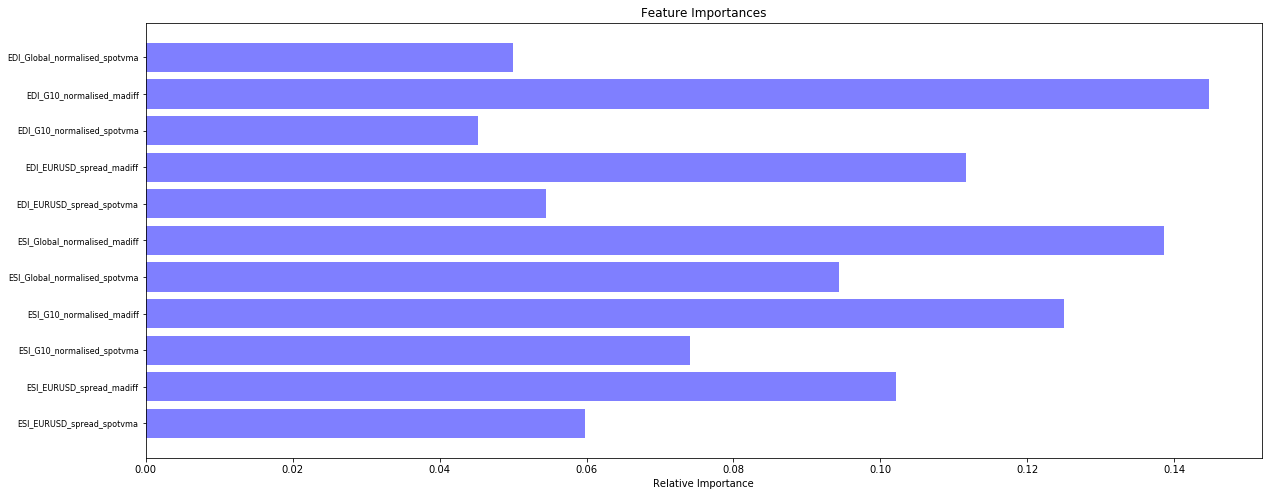

In [6]:
from matplotlib import pyplot as plt
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20,8))
plt.title('Feature Importances')
plt.barh(range(len(importances)), importances, color='b', align='center', alpha = 0.5)
#plt.yticks(range(len(indices)), )
plt.xlabel('Relative Importance')
plt.yticks(range(len(importances)), T_features, fontsize=8)
plt.show()

In [7]:
#from run_decision_tree import trend_estimate_backtester

def trend_estimate_backtester(test, results, trend_model):
    predictions = pd.DataFrame({"Date": test['Date'], "Predictions": results})
    test_results = pd.merge(test, predictions, how="left", on="Date").fillna(0)
    # calculate the returns of the signal
    test_results["scaled_signal"] = test_results['Predictions'].shift(2).rolling(trade_horizon).sum() / trade_horizon
    test_results['strat_returns'] = test_results[trend_model] * test_results['scaled_signal']
    test_results['strat_returns_sum'] = test_results['strat_returns'].cumsum()
    return test_results
test_results = trend_estimate_backtester(test,results,trend_model)
test_location = r"C:\Users\edgil\Documents\Masters\dissertation\data\best_results\trend_estimate_results\model%s_TH%s_ntree%s_classifier%s_riskadj%s.csv" % (
    trend_model, trade_horizon, ntree ,use_classifier, use_risk_adjusted)
test_results.to_csv(test_location, index = False)

NameError: name 'results' is not defined

In [13]:
# save the tree from clf
# visualise the data
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

tree.export_graphviz(clf, out_file=dot_data, class_names=['Reduce Exp',"Increase Exp"]
                     , filled=True, rounded=True, special_characters = True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
tree_location = r"C:\Users\edgil\Documents\Masters\dissertation\data\best_results\trend_estimate_results\model%s_TH%s_ntree%s_classifier%s_riskadj%s.pdf" % (
    trend_model, trade_horizon, ntree ,use_classifier, use_risk_adjusted)
graph.write_pdf(tree_location) 

True